In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/MyDrive/Sirius/
%ls

/content/drive/MyDrive/Sirius
comments.txt  model.py      requirements.txt  stage2_1.ipynb  Untitled0.ipynb
dev_dataset/  ood_samples/  stage1_1.ipynb    stage2.ipynb    utils.py
id_samples/   __pycache__/  stage1.ipynb      test.ipynb      weights.h5


# Метод для распознавания OOD данных
Для распозначания OOD данных использовался метод вычисляющий mahalonis distance(http://arxiv.org/abs/1807.03888). Так как он показывает наиболее лучшие результаты в тестах(http://arxiv.org/abs/2107.02568) и не значительно увеличивает время работы модели.

# Импорт бибилиотек и инициализация некоторых переменных

In [26]:

from model import InceptionResNetV1
import utils
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import tensorflow_datasets as tfds
import os
import random

from sklearn import covariance
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [27]:
id_path = './id_samples'
ood_path = './ood_samples'
target_size = (160, 160)
model = utils.face_model
treshold_compare = 0.4 # порог для косинусного расстояния, заданный в файле utils

In [28]:
def calculate_results_to_df(df, model, dir_path, is_ood_label):
  """Подсчитывает эмбединги и уверенность в предсказаниях;
  Сохраняет их в заданный DataFrame"""
  samples = os.listdir(dir_path)
  target_size = model.target_size

  # counter = 0
  for i, im_name in tqdm(enumerate(samples), total=len(samples)):
    im = cv2.imread(f'{dir_path}/{im_name}')
    im = im[...,::-1]
    im = utils.__resize(im, target_size)
    output = my_model(im)
    confidence, embedding = output['confidence'], output['embedding']
    df.loc[len(df)] = {'name': im_name, 'embedding': embedding,'confidence': confidence, 'is_ood_label': is_ood_label}
    # counter += 1
    # if counter>=189:
    #   break
  return len(df)


In [29]:
def compare(emb1, emb2):
  """Косинусное расстояние между emb1 и  emb2"""
  distance = utils.__calculate_cosine(emb1, emb2)
  return distance

# Модификация модели
Реализован класс, в котором для получения уверенности в предсказании определяется с помощью mahalanobis distance. <br>
Перед использованием модели необходимо подсчитать среднее и ковариация на имеющихся ID данных,что вычисляет метод fit_stat. <br>
__**При вызове модель возвращает словарь `{confidence, embedding}`.**__
Confidence вычисляется через нормализацию расстояния mahanobis, что выполняется при вызове функции normalize.

In [30]:
class MahalanobisModel:
  def __init__(self, model):
    self.target_size = (160, 160)
    self.model = model
    self.mean = None
    self.cov = None
    self.inv_cov = None
    self.embeddings = None
    self.mahalanobis = None

  def fit_stat(self, embeddings: np.array):
    self.embeddings = embeddings

    self.mean = np.mean(self.embeddings, axis=0)
    self.cov = np.cov(self.embeddings.T)
    self.inv_cov = np.linalg.inv(self.cov)

    self.mahalanobis = np.array([self.mahalanobis_distance(emb) for emb in self.embeddings])
    self.mahalanobis_min = np.min(self.mahalanobis)
    self.mahalanobis_max = np.max(self.mahalanobis)
    self.mahalanobis_range = self.mahalanobis_max - self.mahalanobis_min
    return self.mean, self.cov

  def normalize(self, distance):
    return (distance - self.mahalanobis_min) / self.mahalanobis_range

  def mahalanobis_distance(self, embedding):
    diff = embedding - self.mean
    distance = np.sqrt(diff @ self.inv_cov @ diff.T)
    return distance


  def __call__(self, image, training=False):
    assert self.embeddings is not None
    embedding = self.model(image, training=training).numpy()
    dist = self.mahalanobis_distance(embedding)
    congidence = np.clip(1 - self.normalize(dist), 0.0, 1.0)
    return {'confidence': congidence, 'embedding': embedding}

In [31]:

my_model = MahalanobisModel(model)


"""Подсчет эмбедингов для ID данных"""
embeddings = []
id_samples = os.listdir(id_path)
print("Calculate embeddings: ")
for im_name in tqdm(id_samples, total=len(id_samples)):
  im_path = f'{id_path}/{im_name}'
  im_no_resize = cv2.imread(im_path)
  im_no_resize = im_no_resize[...,::-1]
  im = utils.__resize(im_no_resize, target_size)
  embeddings.append(model(im, training=False).numpy()[0])
embeddings = np.array(embeddings)
""""""

my_model.fit_stat(embeddings)
df_mahalanobis  = pd.DataFrame(columns=['name', 'embedding', 'confidence', 'is_ood_label'])
print("\nCalculate id samples: ")
calculate_results_to_df(df_mahalanobis, my_model, id_path, is_ood_label=0) # вычисление DataFrame для ID данных
print("\nCalculate ood samples: ")
calculate_results_to_df(df_mahalanobis, my_model, ood_path, is_ood_label=1) # вычисление DataFrame для OOD данных

Calculate embeddings: 


100%|██████████| 1477/1477 [16:27<00:00,  1.50it/s]



Calculate id samples: 


100%|██████████| 1477/1477 [17:12<00:00,  1.43it/s]



Calculate ood samples: 


100%|██████████| 628/628 [07:09<00:00,  1.46it/s]


2105

In [32]:
df_mahalanobis['confidence']  = df_mahalanobis['confidence'].apply(lambda x: x[0][0])

# Выбор порога для OOD данных
Исходя из графика выбрал treshold=0.42

<Axes: >

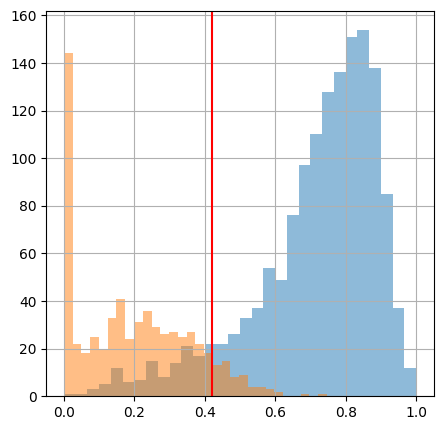

In [33]:
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
treshold_ood = 0.42
ax1.axvline(x=treshold_ood, color='r')
df_mahalanobis[df_mahalanobis['is_ood_label']==0]['confidence'].hist(ax=ax1, bins=30, alpha=0.5)
df_mahalanobis[df_mahalanobis['is_ood_label']==1]['confidence'].hist(ax=ax1, bins=30, alpha=0.5)

# Подсчет метрик
Считаются матрицы с истинными значениями схожести изображений(одинаковые лица) и с косинусными расстояниями между изображениями.

In [34]:

faces = set(map(lambda x: x[:-6], id_samples))
id_samples_clear = list(map(lambda x: x[:-6], id_samples))

In [35]:
def get_face(im_name):
  for face in faces:
    if face in im_name:
      return face
  raise AttributeError()

In [36]:
df_mahalanobis['face'] = df_mahalanobis['name'].apply(get_face) # лицо на изображении
df_mahalanobis['is_ood'] = df_mahalanobis['confidence'].apply(lambda x: int(x < treshold_ood)) # является ли изображение OOD

predictions = np.zeros((len(df_mahalanobis), len(df_mahalanobis)), dtype=np.float32) # матрица с расстояниями
labels = np.zeros((len(df_mahalanobis), len(df_mahalanobis)), dtype=np.float32) # митрица с истинными значениями

In [37]:
def calculate_metrics(df, compare, treshold_compare, is_ood_label=None):
  if is_ood_label==None:
    df_mahalanobis = df
  else:
    df_mahalanobis = df[df['is_ood_label']==is_ood_label]
  predictions = np.zeros((len(df_mahalanobis), len(df_mahalanobis)), dtype=np.float32) # матрица с расстояниями
  labels = np.zeros((len(df_mahalanobis), len(df_mahalanobis)), dtype=np.float32) # митрица с истинными значениями
  for i in tqdm(range(len(df_mahalanobis)), total=len(df_mahalanobis)):
    for j in range(len(df_mahalanobis)):
      row1 = df_mahalanobis.iloc[i]
      row2 = df_mahalanobis.iloc[j]
      labels[i, j] = int(row1['face']==row2['face'])
      predictions[i, j] = compare(row1['embedding'][0], row2['embedding'][0])
  labels_flat       = np.reshape(labels, (1, -1))[0] # преобразование матрицы в вектор
  predictions_flat  = np.reshape(predictions <= treshold_compare, (1, -1))[0] # преобразование матрицы в вектор

  labels_flat       = labels_flat.astype(np.uint8)
  predictions_flat  = predictions_flat.astype(np.uint8)

  recall = recall_score(labels_flat, predictions_flat, average='binary')
  precision = precision_score(labels_flat, predictions_flat, average='binary')
  f1 = f1_score(labels_flat, predictions_flat, average='binary')
  acuuracy = accuracy_score(labels_flat, predictions_flat)
  return labels_flat, predictions_flat, recall, precision, f1, acuuracy

# Подсчет метрик для ID данных

In [40]:
"""Вычисление метрик для ID данных"""
_, _, recall_id, precision_id, f1_id, accuracy_id = calculate_metrics(df_mahalanobis, compare, treshold_compare, is_ood_label=0)

100%|██████████| 1477/1477 [06:40<00:00,  3.68it/s]


In [41]:

print(f'{f1_id=:.3f}, {recall_id=:.3f}, {precision_id=:.3f}, {accuracy_id=:.3f}')

f1_id=0.021, recall_id=0.589, precision_id=0.011, accuracy_id=0.889


# Подсчет FPR@TPR=95%, AUROC

FPR@TPR=95%: 0.2182
AUC: 0.9688


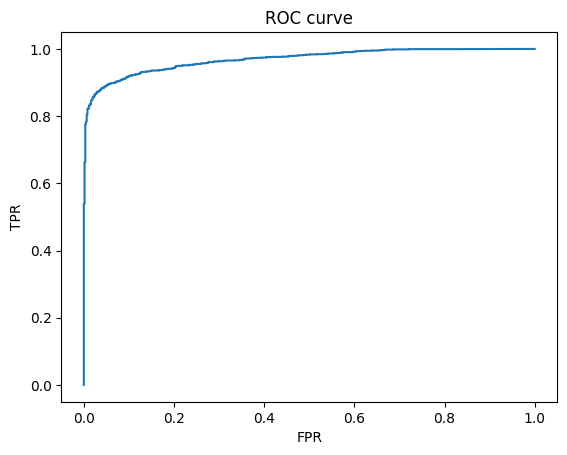

In [42]:
ood_labels = df_mahalanobis['is_ood_label'].values
ood_predictions = df_mahalanobis['confidence'].values
fpr, tpr, th = roc_curve(ood_labels,  ood_predictions, pos_label=0)
auroc = 1 - roc_auc_score(ood_labels, ood_predictions)
# print(fpr, tpr)
tpr95_ind = np.where(tpr>=0.95)[0][0]
fpr_tpr95 = fpr[tpr95_ind]
print(f'FPR@TPR=95%: {fpr_tpr95:.4f}')
print(f'AUC: {auroc:.4f}')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()